In [4]:
library(ggplot2)
library(dplyr)
library(grid)
library(repr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [5]:
options(repr.plot.width=10, repr.plot.height=5)

In [6]:
data <- read.csv("../traffic-data.csv")

In [7]:
data$crawl_date <- as.POSIXct(strptime(data$crawl_date, format="%A %b %d %H:%M:%S UTC %Y"), tz='UTC')
data$crawl_date <- as.POSIXlt(data$crawl_date, tz="Africa/Cairo")
data$report_date        <- data$crawl_date
data$report_date$hour   <- (data$crawl_date$hour - data$rd.rp.hr) %% 24
data$report_date$minute <- data$crawl_date$minute - data$rd.rp.mn
data$hour <- data$report_date$hour
data$wday <- data$report_date$wday
nm <- names(data)
nm <- nm[!grepl("^ad|crawl_date", nm)]
data.unq <- data[!duplicated(data[, c('rd.rp.cmid')]), ]
data.weekend <- data.unq[data.unq$report_date$wday >= 5, ]
data.workday <- data.unq[data.unq$report_date$wday < 5, ]

In [9]:
nm

[1] "rd.nm"        "rd.ri"        "rd.stid"      "rd.hr"        "rd.mn"       
 [6] "rd.new"       "rd.img"       "rd.cl"        "rd.strq"      "rd.cmrq"     
[11] "rd.rp.nm"     "rd.rp.fullnm" "rd.rp.hr"     "rd.rp.mn"     "rd.rp.stid"  
[16] "rd.rp.cm"     "rd.rp.cmid"   "rd.rp.rpImg"  "rd.rp.img"    "rd.rp.type"  
[21] "report_date"  "hour"         "wday"

In [5]:
cairo.roads <- read.csv("cairo-roads-ids.csv")
alex.roads <- read.csv("alex-roads-ids.csv")
cairo.roads$city = "cairo"
alex.roads$city = "alex"
data.unq <- merge(data.unq, rbind(cairo.roads, alex.roads), by="rd.ri")

In [6]:
accidents.hour <- data.unq$report_date$hour[data.unq$rd.rp.stid == 8]
accidents.hour <- na.omit(accidents.hour)

In [7]:
m <- mean(accidents.hour)
s <- sd(accidents.hour)
n <- length(accidents.hour)

In [8]:
error <- qnorm(0.95)*s/sqrt(n)
left <- m - error
right <- m + error

In [9]:
left

[1] 12.68359

In [10]:
right

[1] 13.92955

In [11]:
m <- mean(data.unq$hour)
s <- sd(data.unq$hour)
n <- length(data.unq$hour)

In [12]:
error <- qnorm(0.95)*s/sqrt(n)
left <- m - error
right <- m + error

In [13]:
left

[1] 13.85273

In [14]:
right

[1] 13.90263

mixtools package, version 1.0.4, Released 2016-01-11
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.


Attaching package: ‘mixtools’

The following object is masked from ‘package:grid’:

    depth



number of iterations= 107 


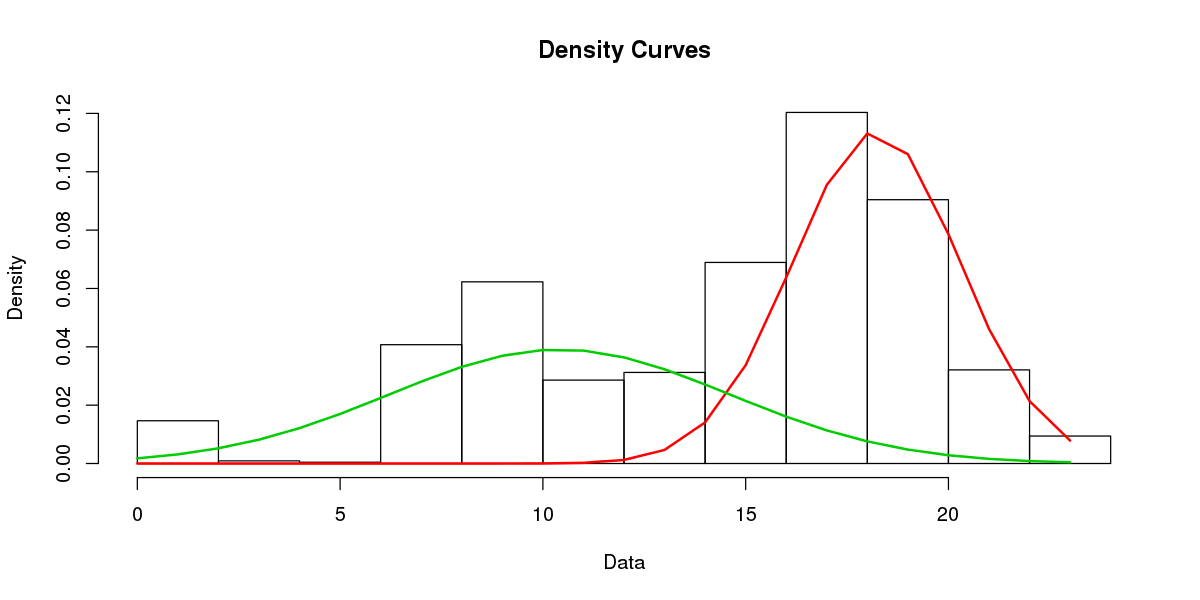

In [15]:
library(mixtools)

#Fit two Normals
dist = normalmixEM(data.unq$hour[!is.na(data.unq$rd.rp.stid) & data.unq$rd.rp.stid > 3 & data.unq$rd.rp.stid < 6], lambda = 0.5)
plot(dist, density=TRUE, loglik=FALSE)

In [16]:
dist$mu

[1] 18.22302 10.41099

In [17]:
dist$sigma

[1] 2.066198 4.190219

number of iterations= 69 


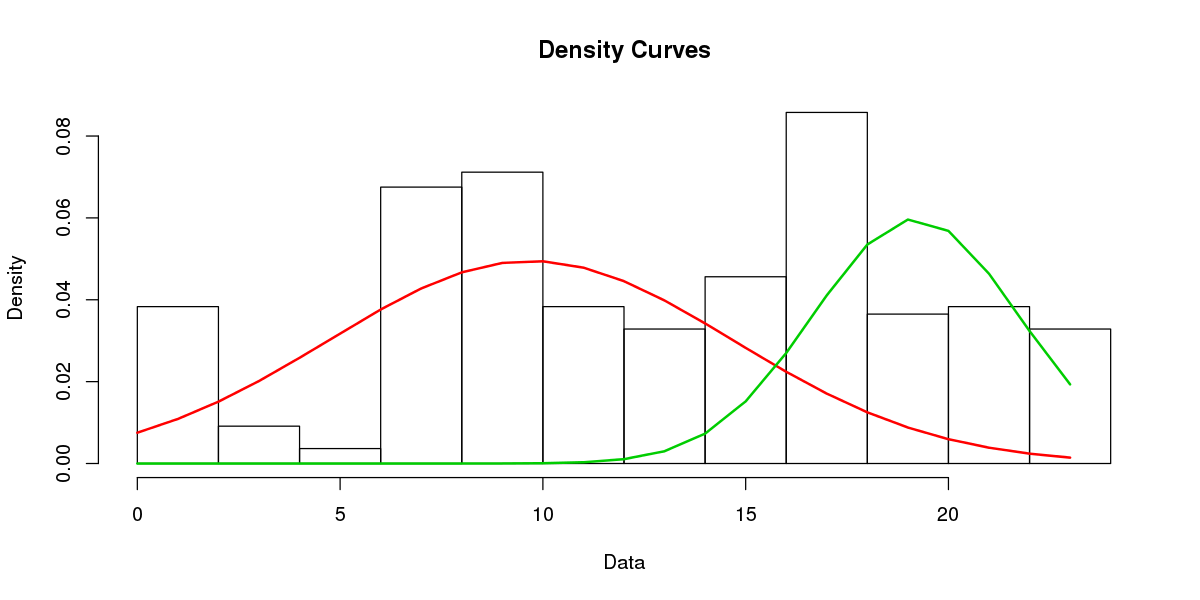

In [18]:
dist = normalmixEM(accidents.hour, lambda = 0.5)
plot(dist, density=TRUE, loglik=FALSE)

In [19]:
dist$mu

[1]  9.704257 19.194225

In [20]:
dist$sigmdda

NULL

### Normalize

In [49]:
data.unq$road.is.za7ma <- data.unq$rd.stid > 3 & data.unq$rd.stid < 6
data.unq$road.is.mshza7ma <- data.unq$rd.stid <= 3
data.unq$report.is.za7ma <- data.unq$rd.rp.stid > 3 & data.unq$rd.rp.stid < 6
data.unq$report.is.mshza7ma <- data.unq$rd.rp.stid <= 3

In [50]:
road.dist <- data.unq[, c("hour", "road.is.za7ma", "road.is.mshza7ma", "city", "report.is.za7ma", "report.is.mshza7ma")] %>%
filter(!is.na(road.is.za7ma)) %>% filter(!is.na(report.is.za7ma)) %>%
group_by(hour) %>%
summarize(za7ma=sum(road.is.za7ma), mshza7ma=sum(road.is.mshza7ma), za7ma.per=za7ma/mshza7ma,
         report.za7ma=sum(report.is.za7ma), report.mshza7ma=sum(report.is.mshza7ma),
         report.za7ma.per=report.za7ma/(report.za7ma + report.mshza7ma))

In [125]:
#install.packages("gridExtra", repos='http://cran.us.r-project.org')
install.packages("igraph", repos='https://cran.r-project.org')

Warning message:
: unable to access index for repository https://cran.r-project.org/src/contribWarning message:
: package ‘ggplot2’ is not available (for R version 3.2.2)

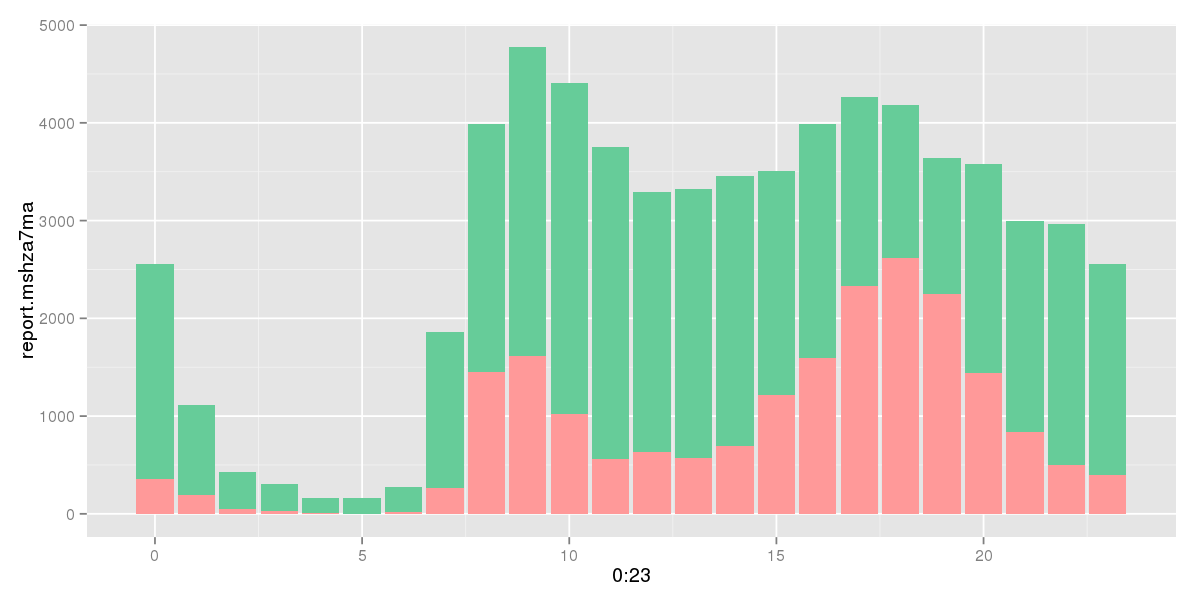

In [52]:
p <- ggplot(data=road.dist) 
p <- p + geom_bar(aes(x=0:23, y=report.mshza7ma), fill="#66CC99", stat="identity")
p <- p + geom_bar(aes(x=0:23, y=report.za7ma), fill="#FF9999", stat="identity")
p

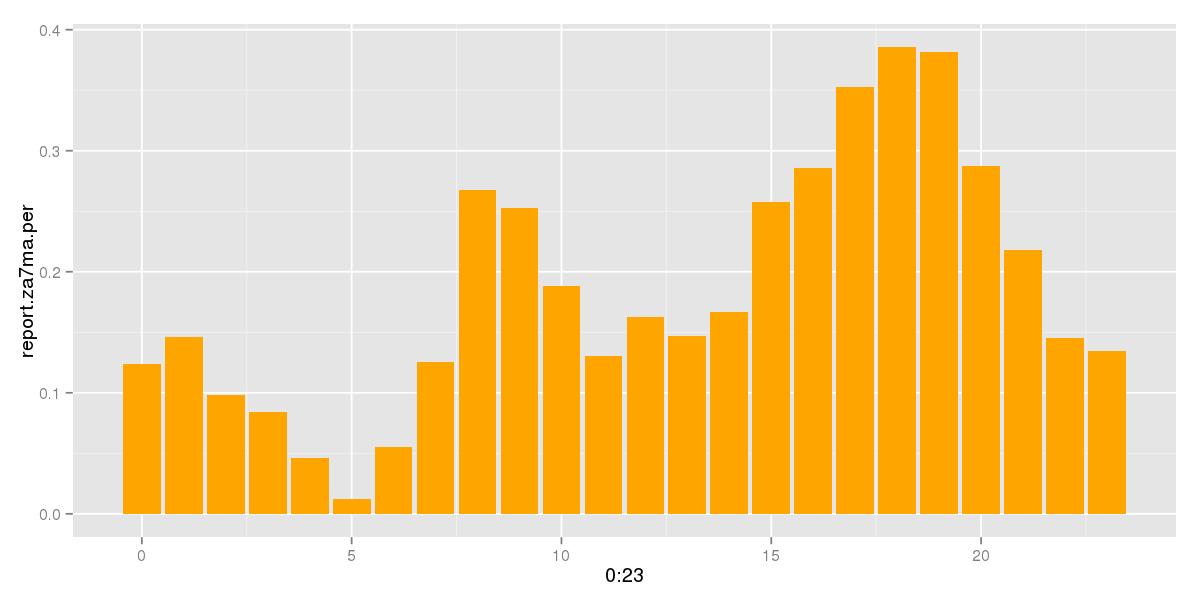

In [54]:
p <- ggplot(data=road.dist)
p <- p + geom_bar(aes(x=0:23, y=report.za7ma.per), fill="orange", stat="identity")
p

In [33]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  require(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

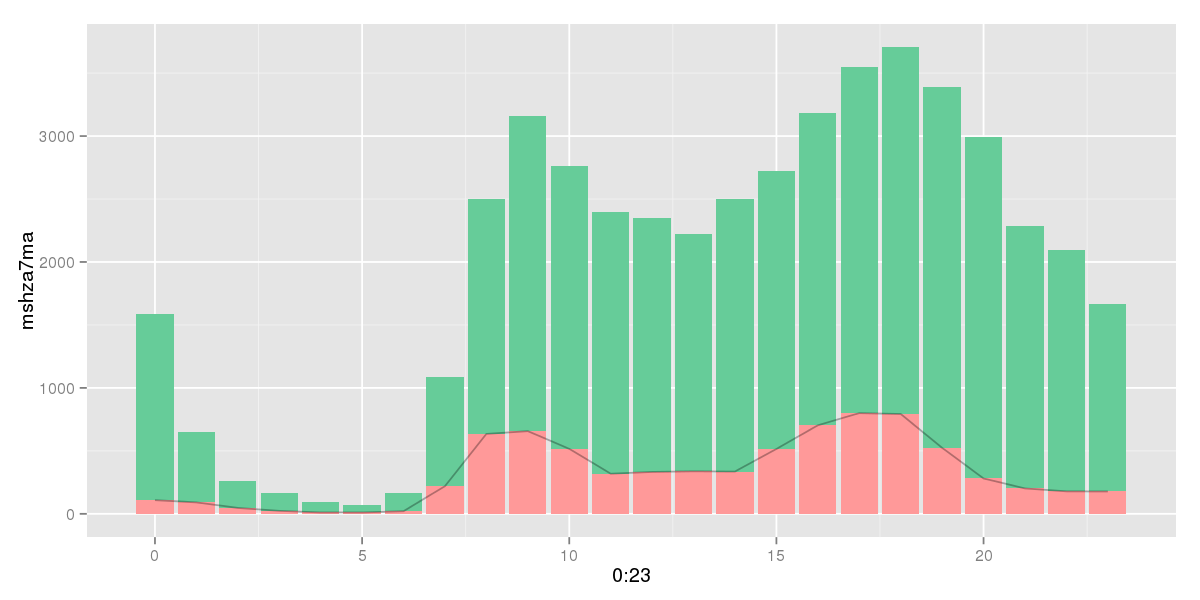

In [56]:
p <- ggplot(data=road.dist) 
p <- p + geom_bar(aes(x=0:23, y=mshza7ma), fill="#66CC99", stat="identity")
p <- p + geom_bar(aes(x=0:23, y=za7ma), fill="#FF9999", stat="identity")
p <- p + geom_line(aes(x=0:23, y=za7ma), fill="black", alpha=0.3)
p
#p1 <- ggplot(data=road.hour.dist) + geom_bar(aes(x=0:23, y=mshza7ma), fill="#66CC99", stat="identity")

#multiplot(p1, p, cols=2)

In [35]:
#### Let's have a look on all weekdays

In [36]:
data.unq$road.is.za7ma <- data.unq$rd.stid > 3 & data.unq$rd.stid < 6 & data.unq$rd.hr < 1
data.unq$road.is.mshza7ma <- data.unq$rd.stid <= 3 & data.unq$rd.hr < 1
road.hour.day.dist <- data.unq[, c("hour", "wday", "road.is.za7ma", "road.is.mshza7ma", "city")] %>% filter(city == "cairo") %>% filter(!is.na(road.is.za7ma)) %>% group_by(hour, wday) %>%
summarize(za7ma=sum(road.is.za7ma), mshza7ma=sum(road.is.mshza7ma), za7ma.per=za7ma/mshza7ma)

In [37]:
road.hour.day.dist

,hour,wday,za7ma,mshza7ma,za7ma.per
1,0,0,45,256,0.1757812
2,0,1,5,172,0.02906977
3,0,2,9,121,0.07438017
4,0,3,17,125,0.136
5,0,4,1,248,0.004032258
6,0,5,13,212,0.06132075
7,0,6,14,299,0.04682274
8,1,0,26,97,0.2680412
9,1,1,0,23,0
10,1,2,7,49,0.1428571


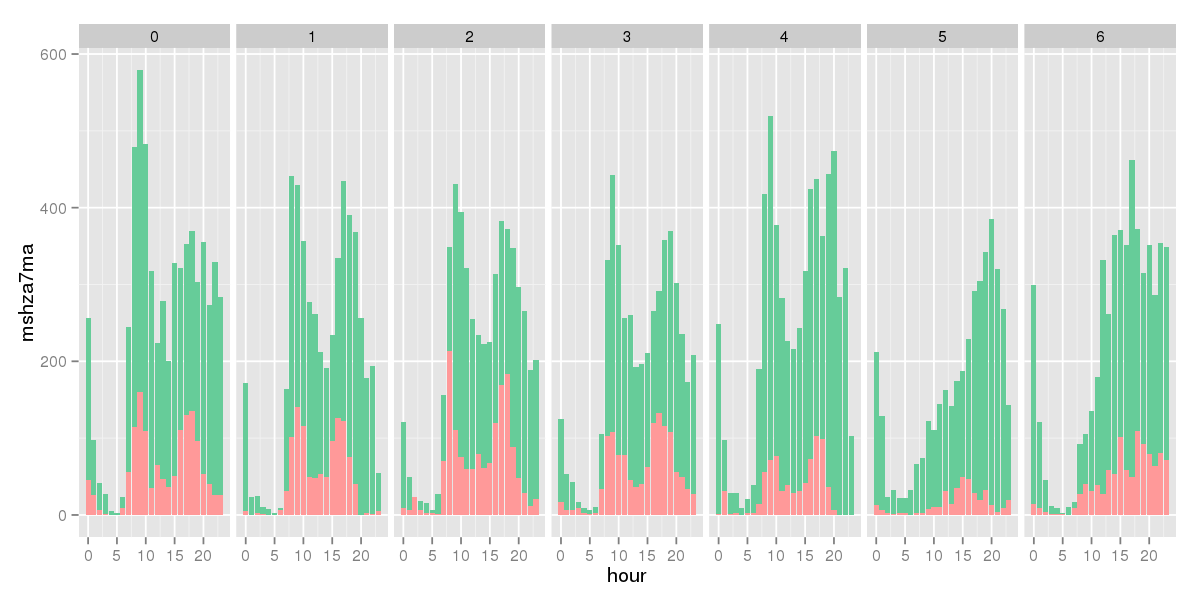

In [38]:

p <- ggplot(data=road.hour.day.dist) 
p <- p + facet_grid(~wday)
p <- p + geom_bar(aes(x=hour, y=mshza7ma), fill="#66CC99", stat="identity")
p <- p + geom_bar(aes(x=hour, y=za7ma), fill="#FF9999", stat="identity")
p 

In [39]:
x <- data.unq$rd.nm[data.unq$city == "cairo"]

### Road name analysis 

In [116]:
data.unq$rd.nm <- as.character(data.unq$rd.nm)
data.unq$road.name <- sapply(data.unq$rd.nm, function(x){unlist(strsplit(x, ";"))[1]})
data.unq$road.direction <- sapply(data.unq$rd.nm, function(x){unlist(strsplit(x, ";"))[2]})
data.unq$road.direction.from <- sapply(data.unq$road.direction, function(x){unlist(strsplit(x, "To"))[1]})
data.unq$road.direction.to <- sapply(data.unq$road.direction, function(x){unlist(strsplit(x, "To"))[2]})

In [117]:
data.unq[, c("road.direction.from", "road.direction.to")] %>% unique()

,road.direction.from,road.direction.to
1,Mohandessin,West ElBalad
1549,West ElBalad,Mohandessin
3125,Da2ery,Kornish Giza
3837,NA,NA
4582,Autostrad,Moneeb
7580,Moneeb,Autostrad
11402,Ba7ary,Sidi Gaber
11630,Sidi Gaber,Ba7ary
11876,Sidi Gaber,Gleem
12127,Gleem,Sidi Gaber


In [98]:
unlist(strsplit("Kobry 15 Mayo;Mohandessin To West ElBalad", ";"))[1]

[1] "Kobry 15 Mayo"

In [96]:
unlist(c)[1]

[1] "Kobry 15 Mayo"

In [118]:
data.unq %>% select(road.name, road.direction.from, road.direction.to) %>% 
group_by(road.direction.from, road.direction.to) %>% summarize(count=length(road.name))

,road.direction.from,road.direction.to,count
1,,Da2ery,360
2,,Moneeb Direction,1163
3,,Sa7rawy,343
4,,Sa7rawy Direction,1048
5,21,El Maw2af El Gedid,54
6,21,Mansheya,62
7,21,Sa7rawy,43
8,2al3a,Da2ery,484
9,2al3a,Kobry 6 October,2026
10,2al3a,Kornich ElNile,580


Warning message:
: unable to access index for repository 
http://cran.stat.sfu.ca/src/contribWarning message:
: package ‘igraph’ is not available (for R version 3.2.2)